In [1]:
import numpy as np
import framework as tf
import os
from data_config import load_batch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

ROOT = os.getcwd()+'/cifar-10-batches-py/'
X_train, y_train = load_batch(ROOT+'data_batch_1')
X_test, y_test = load_batch(ROOT+'test_batch')

In [2]:
######### Mini_batch generating function ###########

# create a generator to fetch mini batches of data
def get_minibatch(X, y, batch_size=16):
    n, k, i = len(X_train), batch_size, 0
    while True:
        yield X[i:i+k], y[i:i+k]
        i = (0 if i > n-k else i+k)
# we'll call the generator 'sample'
sample = get_minibatch(X_train, y_train, batch_size=16)
a, b = next(sample)
a.shape, b.shape

((16, 3, 32, 32), (16,))

Now we will build the neural net. We are going to use the simplest Convolution net we can.
The architecture is one convolution/relu/pool, followed by two fully connected layers:
X (N,3,32,32) -> conv2D (N,12,32,32) (s=1,p=1) -> relu -> 2x2 pool (N, 12,16,16) -> flatten (N,3072) -> affine/relu (N,200) -> affine (N,10) -> loss

## Numerical gradient checking of convnet

In [42]:
########## Temporary graph used for gradient checking. We put in small parameter values #########

g = tf.Graph()

N, C, H, W = 3,3,6,6
F, f = 5, 3
h0 = (H//2)*(W//2)*F
h1 = 5
h2 = 4

X = tf.Placeholder(name='X')
filter1 = tf.Variable(np.random.randn(F,C,f,f), name='filter1')
bconv1 = tf.Variable(np.zeros(F), name='bconv1')
conv1 = tf.conv2D(X, filter1, bconv1, stride=1, pad=1, name='conv1')
conv1_relu = tf.relu(conv1, name='conv1_relu')
pool1 = tf.maxpool2D(conv1_relu, height=2, width=2, stride=2, name='pool1')

flat = tf.flatten(pool1, name='flat')
W1 = tf.Variable(np.random.randn(h0,h1)/np.sqrt(h0), name='W1')
b1 = tf.Variable(np.zeros(h1), name='b1')
fc1_z = tf.affine(flat, W1, b1, name='fc1_z')
fc1 = tf.relu(fc1_z, name='fc1')

W2 = tf.Variable(np.random.randn(h1,h2)/np.sqrt(h1), name='W2')
b2 = tf.Variable(np.zeros(h2), name='b2')
scores = tf.affine(fc1, W2, b2, name='scores')

y = tf.Placeholder(name='y')
J = tf.softmax_loss(scores, y, name='softmax')

[X, filter1, bconv1, conv1, conv1_relu, pool1, flat, W1, b1, fc1_z, fc1, W2, b2, scores, y, softmax]


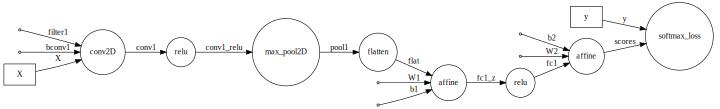

In [43]:
sess = tf.Session(g)
print(sess.order)
g.make_graph()

In [44]:
from gradient_checking import num_grad
from gradient_checking import rel_error

# Do a forward/backward pass to retrieve gradient
# Note, that by definition variables are not altered during the forward pass
# only operators are. Then, we can safely perform this
X_batch = np.random.randn(N,C,H,W)
y_batch = np.random.randint(h2,size=N)
data = {'X':X_batch, 'y':y_batch}
sess.forward(J, feed_dict=data)
sess.backward()

print("Checking backprop derivatives numerically for each variable...")
for var in sess.graph.variables:
    def func(x):
        var.output = x
        return sess.forward(J, feed_dict=data)
    num_dz = num_grad(func, var.output, 1)
    dz = var.gradient
    print(f"d{var} error: {rel_error(num_dz, dz)}")

dfilter1 error: 3.560919733442892e-11
db2 error: 1.4308280265245919e-11
dW2 error: 2.985084905616155e-12
dW1 error: 3.3860404218558253e-12
db1 error: 1.987142474369173e-11
dbconv1 error: 1.6754936738952724e-11


## Two-layer neural net

In [117]:
#################  Two-layer Neural net  ##################

g = tf.Graph()
h0,h1,h2 = 3072, 200, 10
X = tf.Placeholder(name='X')
flat = tf.flatten(X, name='flatten')
W1 = tf.Variable(np.random.randn(h0,h1)/np.sqrt(h0), name='W1')
b1 = tf.Variable(np.zeros(h1), name='b1')

z1 = tf.affine(flat, W1, b1, name='z1')
a1 = tf.tanh(z1, name='a1')

W2 = tf.Variable(np.random.randn(h1,h2)/np.sqrt(h1), name='W2')
b2 = tf.Variable(np.zeros(h2), name='b2')
scores = tf.affine(a1, W2, b2, name='scores')

y = tf.Placeholder(name='y')
J = tf.svm_loss(scores, y, name='softmax')

Checking the correct topological sort is generated...
[X, flatten, W1, b1, z1, a1, W2, b2, scores, y, softmax]
Checking the forward pass...
loss = 12.584359667337392
Success.
Checking the backward pass...
Success.


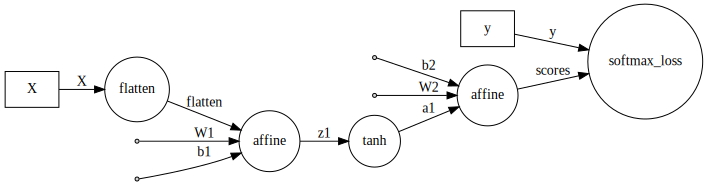

In [118]:
# open the session
sess = tf.Session(g)

# check that the topological sort worked
print("Checking the correct topological sort is generated...")
print(sess.order)

# test the forward/backward pass on a minibatch
data = {'X':X_train[:32], 'y':y_train[:32]}
print("Checking the forward pass...")
print("loss =",sess.forward(J, feed_dict=data))
print("Success.")
print("Checking the backward pass...")
sess.backward()
print("Success.")

# compile the computation graph
g.make_graph()

In [107]:
### We first train to a small dataset, to ensure that we can overfit
### We train the model, using a basic SGD update rule.
### Every so often we print the loss and previous minibatch accuracy

# helpful function to predict class
def predict(sess=sess,data=data):
    return np.mean(np.argmax(sess.forward(scores,feed_dict=data),axis=1)==data['y'])

lr = 1e-3
loss_history = []
# data = {'X':X_train[:32].reshape(32,-1), 'y':y_train[:32]}
data = {'X':X_train[:32], 'y':y_train[:32]}
for i in range(1000):
#     X_batch, y_batch = next(small_sample)
    loss = sess.forward(J, feed_dict=data)
    sess.backward()
    for var in sess.graph.variables:
        var.output -= lr*var.gradient
        var.gradient = None
    if i % 100 == 0:
        print(f"iteration {i}/{1000}. loss ={loss:.2f}")
    if i % 100 == 0:
        print(f"Training accuracy:, {100*predict():.2f}%")
    loss_history.append(loss)

iteration 0/1000. loss =11.49
Training accuracy:, 12.50%
iteration 100/1000. loss =3.34
Training accuracy:, 50.00%
iteration 200/1000. loss =1.75
Training accuracy:, 71.88%
iteration 300/1000. loss =1.00
Training accuracy:, 81.25%
iteration 400/1000. loss =0.82
Training accuracy:, 93.75%
iteration 500/1000. loss =0.55
Training accuracy:, 96.88%
iteration 600/1000. loss =0.45
Training accuracy:, 96.88%
iteration 700/1000. loss =0.35
Training accuracy:, 96.88%
iteration 800/1000. loss =0.28
Training accuracy:, 96.88%
iteration 900/1000. loss =0.23
Training accuracy:, 100.00%


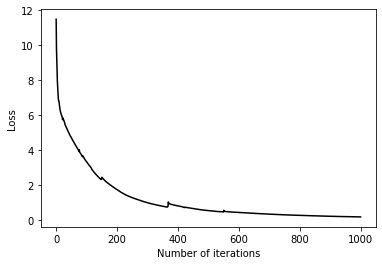

In [112]:
plt.plot(loss_history, 'k')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.show()

# Three-layer convolutional neural net

In [120]:
#################  Three-layer Convolutional Neural Net  ##################

g = tf.Graph()

N, C, H, W = 16,3,32,32
F, f = 6, 3
h0 = (H//2)*(W//2)*F
h1 = 100
h2 = 10

X = tf.Placeholder(name='X')
filter1 = tf.Variable(np.random.randn(F,C,f,f), name='filter1')
bconv1 = tf.Variable(np.zeros(F), name='bconv1')
conv1 = tf.conv2D(X, filter1, bconv1, stride=1, pad=1, name='conv1')
conv1_relu = tf.relu(conv1, name='conv1_relu')
pool1 = tf.maxpool2D(conv1_relu, height=2, width=2, stride=2, name='pool1')

flat = tf.flatten(pool1, name='flat')
W1 = tf.Variable(np.random.randn(h0,h1)/np.sqrt(h0), name='W1')
b1 = tf.Variable(np.zeros(h1), name='b1')
fc1_z = tf.affine(flat, W1, b1, name='fc1_z')
fc1 = tf.tanh(fc1_z, name='fc1')

W2 = tf.Variable(np.random.randn(h1,h2)/np.sqrt(h1), name='W2')
b2 = tf.Variable(np.zeros(h2), name='b2')
scores = tf.affine(fc1, W2, b2, name='scores')

y = tf.Placeholder(name='y')
J = tf.svm_loss(scores, y, name='softmax')

Checking the correct topological sort is generated...
[X, filter1, bconv1, conv1, conv1_relu, pool1, flat, W1, b1, fc1_z, fc1, W2, b2, scores, y, softmax]
Checking the forward pass...
loss = 9.901772135823824
Success.
Checking the backward pass...
Success.


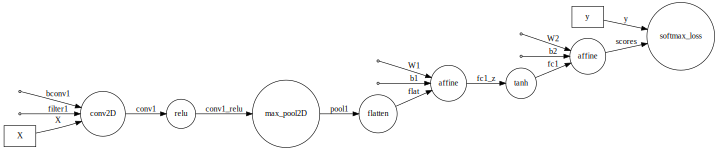

In [121]:
# open the session
sess = tf.Session(g)

# check that the topological sort worked
print("Checking the correct topological sort is generated...")
print(sess.order)

# test the forward/backward pass on a minibatch
data = {'X':X_train[:32], 'y':y_train[:32]}
print("Checking the forward pass...")
print("loss =",sess.forward(J, feed_dict=data))
print("Success.")
print("Checking the backward pass...")
sess.backward()
print("Success.")

# compile the computation graph
g.make_graph()

In [122]:
# helpful function to predict class
def predict(sess=sess,data=data):
    return np.mean(np.argmax(sess.forward(scores,feed_dict=data),axis=1)==data['y'])

lr = 1e-3
loss_history = []
# data = {'X':X_train[:32].reshape(32,-1), 'y':y_train[:32]}
data = {'X':X_train[:32], 'y':y_train[:32]}
for i in range(1000):
#     X_batch, y_batch = next(small_sample)
    loss = sess.forward(J, feed_dict=data)
    sess.backward()
    for var in sess.graph.variables:
        var.output -= lr*var.gradient
    if i % 100 == 0:
        print(f"iteration {i}/{1000}. loss ={loss:.2f}")
    if i % 100 == 0:
        print(f"Training accuracy:, {100*predict():.2f}%")
    loss_history.append(loss)

iteration 0/1000. loss =9.90
Training accuracy:, 6.25%
iteration 100/1000. loss =3.66
Training accuracy:, 50.00%
iteration 200/1000. loss =1.85
Training accuracy:, 75.00%
iteration 300/1000. loss =1.03
Training accuracy:, 87.50%
iteration 400/1000. loss =0.62
Training accuracy:, 90.62%
iteration 500/1000. loss =0.43
Training accuracy:, 93.75%
iteration 600/1000. loss =0.31
Training accuracy:, 93.75%
iteration 700/1000. loss =0.23
Training accuracy:, 93.75%
iteration 800/1000. loss =0.17
Training accuracy:, 96.88%
iteration 900/1000. loss =0.14
Training accuracy:, 100.00%


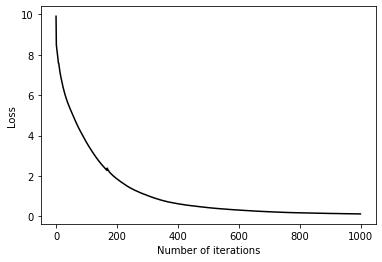

In [124]:
plt.plot(loss_history, 'k')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.show()

In [130]:
# helpful function to predict class
def predict(sess=sess,data=data):
    return np.mean(np.argmax(sess.forward(scores,feed_dict=data),axis=1)==data['y'])

sample = get_minibatch(X_train, y_train, batch_size=16)

lr = 1e-4
loss_history = []
for i in range(1000):
    X_batch, y_batch = next(sample)
    data = {'X':X_batch, 'y':y_batch}
    loss = sess.forward(J, feed_dict=data)
    sess.backward()
    for var in sess.graph.variables:
        var.output -= lr*var.gradient
    if i % 20 == 0:
        print(f"iteration {i}/{1000}. loss ={loss:.2f}")
        print(f"Training accuracy:, {100*predict(data=data):.2f}%")
    loss_history.append(loss)

iteration 0/1000. loss =9.30
Training accuracy:, 12.50%
iteration 20/1000. loss =9.82
Training accuracy:, 6.25%
iteration 40/1000. loss =8.36
Training accuracy:, 18.75%
iteration 60/1000. loss =8.37
Training accuracy:, 12.50%
iteration 80/1000. loss =7.23
Training accuracy:, 31.25%
iteration 100/1000. loss =9.10
Training accuracy:, 18.75%
iteration 120/1000. loss =7.49
Training accuracy:, 12.50%
iteration 140/1000. loss =9.75
Training accuracy:, 6.25%
iteration 160/1000. loss =9.16
Training accuracy:, 18.75%
iteration 180/1000. loss =9.56
Training accuracy:, 6.25%
iteration 200/1000. loss =8.72
Training accuracy:, 12.50%


KeyboardInterrupt: 

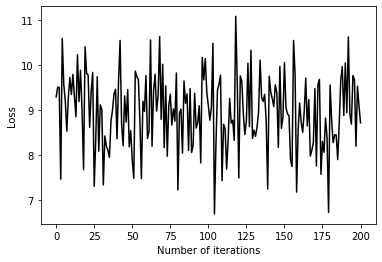

In [131]:
plt.plot(loss_history, 'k')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.show()

# Recurrent neural network

Checking the correct topological sort is generated...
[X1, Wx, h0, Wh, Var12, h1, W_out, b_out, yhat1, X3, X2, h2, h3, yhat2, yhat3, X4, h4, yhat4]


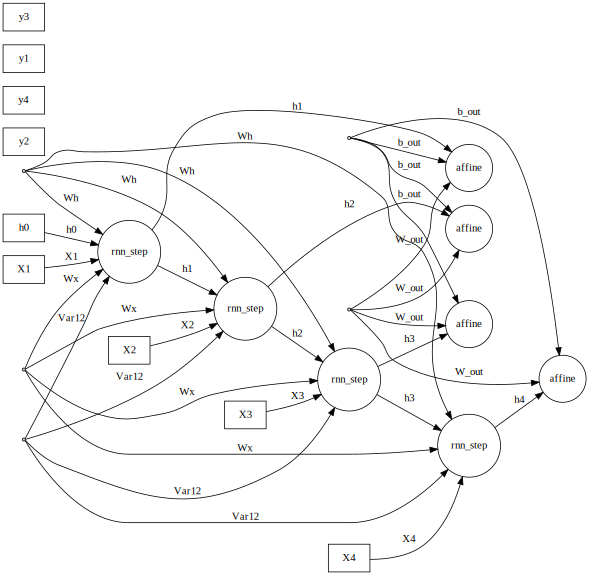

In [189]:
########## Temporary graph used for gradient checking. We put in small parameter values #########

g = tf.Graph()

D, H, V = 4, 3, 2

# input sequence
X1 = tf.Placeholder('X1')
X2 = tf.Placeholder('X2')
X3 = tf.Placeholder('X3')
X4 = tf.Placeholder('X4')

# memory state
h0 = tf.Placeholder('h0')

# recurrent weights
Wx = tf.Variable(np.random.randn(D,H), name='Wx')
Wh = tf.Variable(np.random.randn(H,H), name='Wh')
b = tf.Variable(np.zeros(H))
W_out = tf.Variable(np.random.randn(H,V), name='W_out')
b_out = tf.Variable(np.zeros(V), name='b_out')

# target sequence
y1 = tf.Placeholder('y1')
y2 = tf.Placeholder('y2')
y3 = tf.Placeholder('y3')
y4 = tf.Placeholder('y4')

# RNN structure
h1 = tf.rnn_step(X1, Wx, h0, Wh, b, name='h1')
h2 = tf.rnn_step(X2, Wx, h1, Wh, b, name='h2')
h3 = tf.rnn_step(X3, Wx, h2, Wh, b, name='h3')
h4 = tf.rnn_step(X4, Wx, h3, Wh, b, name='h4')

yhat1 = tf.affine(h1, W_out, b_out, name='yhat1')
yhat2 = tf.affine(h2, W_out, b_out, name='yhat2')
yhat3 = tf.affine(h3, W_out, b_out, name='yhat3')
yhat4 = tf.affine(h4, W_out, b_out, name='yhat4')
# loss2 = tf.add(tf.softmax_loss(y1,yhat1), tf.softmax_loss(y2, yhat2))
# loss3 = tf.add(loss2, tf.softmax_loss(y3, yhat3))
# loss = tf.add(loss3, tf.softmax_loss(y4, yhat4))

# open the session
sess = tf.Session(g)

# check that the topological sort worked
print("Checking the correct topological sort is generated...")
print(sess.order)

# compile the computation graph
g.make_graph()

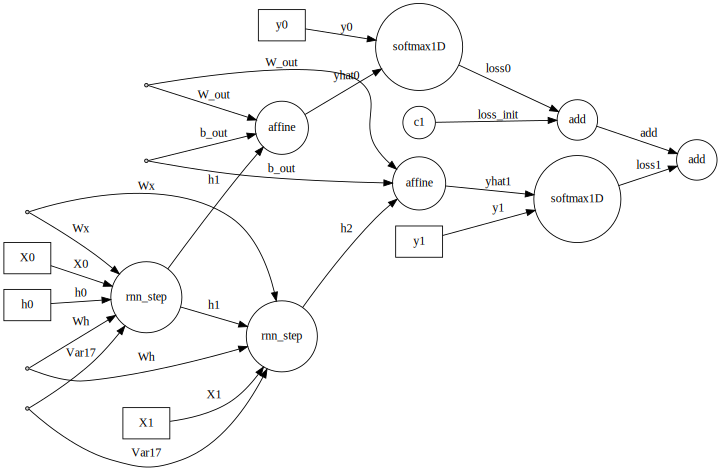

In [263]:
# build recursively
g = tf.Graph()

D, H, V, T = 4, 6, 5, 2

# memory state
h_prev = tf.Placeholder('h0')

# recurrent weights
Wx = tf.Variable(np.random.randn(D,H), name='Wx')
Wh = tf.Variable(np.random.randn(H,H), name='Wh')
b = tf.Variable(np.zeros(H))
W_out = tf.Variable(np.random.randn(H,V), name='W_out')
b_out = tf.Variable(np.zeros(V), name='b_out')

# loss initialization
loss = tf.Constant(0, name='loss_init')

for t in range(T):
    x = tf.Placeholder('X'+str(t))
    y = tf.Placeholder('y'+str(t))
    h_prev = tf.rnn_step(x, Wx, h_prev, Wh, b, name='h'+str(t+1))
    yhat = tf.affine(h_prev, W_out, b_out, name='yhat'+str(t))
    loss = tf.add(loss, tf.softmax1D(yhat, y, name='loss'+str(t)))
# yhat = tf.affine(h_prev, W_out, b_out, name='yhat'+str(T))
# loss = tf.softmax1D(yhat, y, name='loss'+str(T))
g.make_graph()

In [260]:
# Test with some random sequence data
seq = np.random.randint(D,size=T+1)
X = np.zeros((T+1,D))
X[np.arange(T+1),seq]=1
y = seq[1:]
X = X[:-1]
print(X.shape, y.shape)

sess = tf.Session(g)
# sess.order
# g.make_graph()
data = {'h0':np.random.randn(H)}
for t in range(T):
    data['X'+str(t)] = X[t]
    data['y'+str(t)] = y[t]

(2, 4) (2,)


In [261]:
sess.forward(feed_dict=data)
sess.backward()

In [262]:
for op in sess.graph.operators:
    print("Current operator:",op)
    print(op.gradient)

Current operator: yhat2
[-1.39216638 -0.19264509 -0.29158426 -0.27897172 -0.04067543]
Current operator: h1
[[-0.87291789  2.3630067  -0.67075073 -3.48576216  1.31540426  2.45185783]]
Current operator: loss2
1
Current operator: h2
[[-0.64981233 -0.17410388  0.3989985  -2.28495454 -2.74221969 -1.0256974 ]]


In [ ]:
# test the forward/backward pass on a minibatch
data = {'X':X_train[:32], 'y':y_train[:32]}
print("Checking the forward pass...")
print("loss =",sess.forward(J, feed_dict=data))
print("Success.")
print("Checking the backward pass...")
sess.backward()
print("Success.")

